In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from ultralytics import YOLO
import pandas as pd
from PIL import Image
import numpy as np
import cv2
from tqdm import tqdm
import albumentations as A
import shutil
from pathlib import Path
import random

C:\Users\Devashish Uniyal\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setting up file paths and loading up 'yolov5n.pt' to Fine Tune it
DATA_PATH = 'data.yaml'
MODEL_PATH = 'yolov5n.pt'  
OUTPUT_MODEL_PATH = 'yolov5m_self_driving_car.pt'
EPOCHS = 15
IMG_SIZE = 640  
PROJECT_NAME = 'Object-Detection-For-Autonomous-Cars'
EXPERIMENT_NAME = 'yolov5m_autonomous_cars'

In [3]:
# Extracting File Labels
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

with open(DATA_PATH, 'r') as file:
    dataset_info = yaml.safe_load(file)

classes = dataset_info.get('names', {})
if not classes:
    print("No class information found in the dataset.")
else:
    print(f"Classes in the dataset: {classes}")


Classes in the dataset: ['biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck']


In [ ]:
# Displaying Class Labels Distribution
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# From  YAML
dataset_info = {
    'train': r'export\labels'
}

classes = ['biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green',
           'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft',
           'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck']

def visualize_class_distribution():
    if 'train' not in dataset_info:
        print("Train path not found in dataset_info")
        return

    train_path = dataset_info['train']
    annotations = []
    file_count = 0

    for root, _, files in os.walk(train_path):
        for file in files:
            if file.endswith('.txt'):
                file_count += 1
                with open(os.path.join(root, file), 'r') as f:
                    lines = f.readlines()
                    annotations.extend(lines)

    print(f"Found {file_count} .txt files.")
    print(f"Total annotation lines: {len(annotations)}")

    class_ids = []
    for line in annotations:
        if line.strip():
            try:
                class_id = int(line.split()[0])
                class_ids.append(class_id)
            except Exception as e:
                print(f"Malformed line: {line.strip()} | Error: {e}")

    if not class_ids:
        print("No valid class IDs found.")
        return

    class_counts = pd.Series(class_ids).value_counts().sort_index()
    class_counts.index = class_counts.index.map(lambda x: classes[x])

    print("Class counts:\n", class_counts)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='mako')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution in YOLO Annotations')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
visualize_class_distribution()

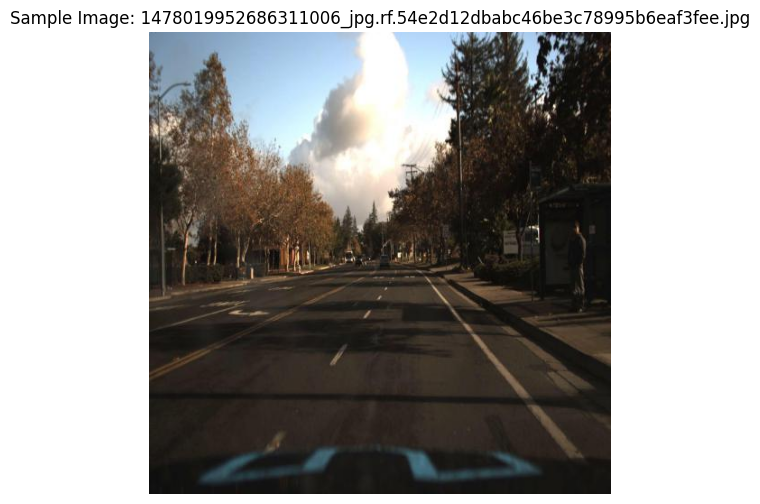

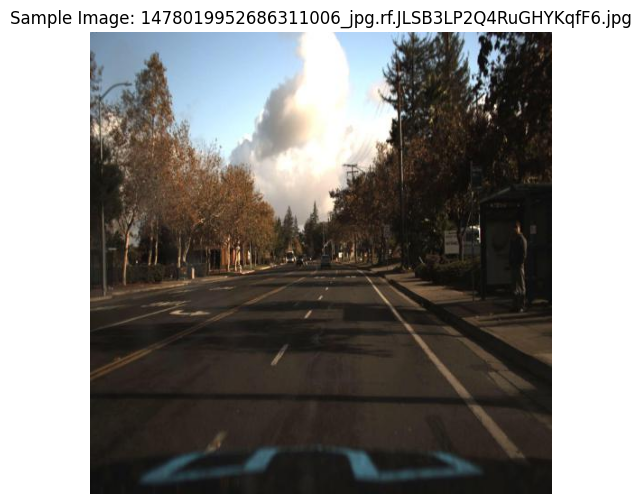

In [5]:
# Displaying Sample images

dataset_info = {
    'train': r'export\images'
}

def visualize_sample_images():
    train_path = dataset_info.get('train', '')
    if not train_path:
        print("Training image path not found in the dataset YAML.")
        return
    
    images = [os.path.join(root, file) for root, _, files in os.walk(train_path) for file in files if file.endswith(('.jpg', '.png'))][:2]
    
    for img_path in images:
        img = Image.open(img_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"Sample Image: {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()

visualize_sample_images()

In [10]:
# Initializing Training parameters and starting model Training
print("Initializing YOLO model...")
model = YOLO(MODEL_PATH)

print(f"Training YOLO model for {EPOCHS} epochs...")

results = model.train(
    data=DATA_PATH,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    project=PROJECT_NAME,
    name=EXPERIMENT_NAME,
    batch=8,              
    augment=True,          
    hsv_h=0.015,          
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=0.3,
    flipud=0.2,
    fliplr=0.4,
    mosaic=1.0,
    mixup=0.2,
    lr0=0.01
)

Initializing YOLO model...
PRO TIP  Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Training YOLO model for 15 epochs...
Ultralytics YOLOv8.2.50  Python-3.10.8 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=data.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=Object-Detection-For-Autonomous-Cars, name=yolov5m_autonomous_cars18, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, spl

train: Scanning C:\Users\Devashish Uniyal\OneDrive\Desktop\Object Detection\export\labels.cache... 29800 images, 3500 backgrounds, 0 corrupt: 100%|██████████| 29800/29800 [00:00<?, ?it/s]

train: WARNING  C:\Users\Devashish Uniyal\OneDrive\Desktop\Object Detection\export\images\1478021875081281646_jpg.rf.bEZPhuyXU5hIovwQSTIp.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\Devashish Uniyal\OneDrive\Desktop\Object Detection\export\images\1478021875081281646_jpg.rf.e9552980cf8c6fef4aa02cb84c6364f5.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\Devashish Uniyal\OneDrive\Desktop\Object Detection\export\images\1478897760163798179_jpg.rf.5Pzrj3Eg3vZuyl7ztKAt.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\Devashish Uniyal\OneDrive\Desktop\Object Detection\export\images\1478897760163798179_jpg.rf.98623be50b02ff17d58f89fddf7a0c6c.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\Devashish Uniyal\OneDrive\Desktop\Object Detection\export\images\1478898145212453716_jpg.rf.6a92d7d7dd523160c990c4e4375bcea9.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\Devashish Uniyal\OneDrive\Desktop\Object Detection\export\images\1478898145212453716_jpg.

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


C:\Users\Devashish Uniyal\AppData\Roaming\Python\Python310\site-packages\ultralytics\data\augment.py:935: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),


In [ ]:
model.save(OUTPUT_MODEL_PATH)
print(f"Trained model saved at {OUTPUT_MODEL_PATH}")


Trained model saved at yolov5m_self_driving_car.pt
